In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
MODEL
"""
# Use a Ladder CNN in addition to the image encoder?
use_cnn = False
# Run the resizing operations after the CNN? (might preserve fine pixel-level details better)
resize_before_cnn = True

# Use LoRA on the mask decoder? (if False, trains the whole decoder)
mask_ft = False
mask_lora = True
mask_r = 8

# use LoRa on the image encoder transformer?
vit_lora = False
vit_r = 8

# train the image encoder's patch embedding CNN? Highly recommended.
vit_patch_embed = True

use_cls_tokens = True

model_size = "vit_t"

"""
TRAINING
"""
run_grad = True

focal_scale = 20
mse_scale = 1
dice_scale = 1
ce_scale = 1
cls_scale = 1

num_refinement_steps = 0

cache_embeddings = True

"""
DATA
"""
use_valid = True
cls_ids = None # any
train_size = None # images
valid_size = 20 # images

use_masks = True
grow_masks = False
growth_radius = 15

# train on semantic segmentation or point/box-to-mask?
tasks = ["sem_seg","point","box","cls"]

points_per_mask = 1

In [3]:
import sys
import os
# sys.path.append(os.path.relpath("./segment-anything"))
# inserting to front instead:
sys.path.insert(0, os.path.relpath("./segment-anything"))
import segment_anything

%cd datasets/
from fine_tune.configs.climbing import *
%cd ..

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported
/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 3123.72it/s]

/home/andrewhealey/sam-fine-tuning


In [4]:
import supervision as sv
from fine_tune.datasets import extract_classes_from_dataset,shrink_dataset_to_size

train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=use_masks
)

if train_size is not None:
    train_dataset = shrink_dataset_to_size(train_dataset,train_size)

if cls_ids is not None:
    print("Selecting classes",[train_dataset.classes[i] for i in cls_ids])
    train_dataset = extract_classes_from_dataset(train_dataset,cls_ids)

if use_valid:
    valid_dataset = sv.DetectionDataset.from_coco(
        images_directory_path=f"{dataset.location}/valid",
        annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
        force_masks=use_masks
    )
else:
    valid_dataset = train_dataset

if valid_size is not None:
    valid_dataset = shrink_dataset_to_size(valid_dataset,valid_size)

if cls_ids is not None:
    valid_dataset = extract_classes_from_dataset(valid_dataset,cls_ids)

Selecting classes ['climbing-holds', 'floor', 'person']


In [5]:
num_classes = len(train_dataset.classes)
num_classes

3

In [6]:
from random import choice
train_dataset.annotations[choice(list(train_dataset.annotations.keys()))].class_id

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2])

In [7]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [8]:
if use_valid:
    valid_names = set(k.split(".rf")[0] for k in valid_dataset.images.keys())
    train_names = set(k.split(".rf")[0] for k in train_dataset.images.keys())

    # Check that there's no training/valid pollution
    assert len(valid_names.intersection(train_names)) == 0,"There is overlap between the training and validation sets."

In [9]:
from persam.load import load_predictor
from fine_tune.samed import LoRA_Mask_Decoder,LoRA_Tiny_Image_Encoder
from fine_tune.ladder_cnn import CNN_SAM

predictor = load_predictor(model_size,num_classes=num_classes)

if mask_lora:
    lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=mask_r)
    mask_decoder = lora_mask_decoder.mask_decoder.cuda()
else:
    mask_decoder = predictor.model.mask_decoder

if vit_lora:
    lora_image_encoder = LoRA_Tiny_Image_Encoder(predictor.model.image_encoder,r=vit_r).cuda()
    image_encoder = lora_image_encoder.image_encoder
else:
    image_encoder = predictor.model.image_encoder

if use_cnn:
    cnn_sam = CNN_SAM(resize_before_cnn=resize_before_cnn).to("cuda")
else:
    cnn_sam = None

Init MaskDecoder True


In [10]:
from fine_tune.common import grow_dataset_masks

if grow_masks:
    grow_dataset_masks(train_dataset,growth_radius=growth_radius)
    grow_dataset_masks(valid_dataset,growth_radius=growth_radius)

In [11]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamNextMaskDataset, RandomPointDataset, SamDummyMaskDataset, SamSemSegDataset, SamComboDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

cache_dir = "./cache"

from torch.utils.data import ConcatDataset

args = [predictor,device,cache_embeddings,cache_dir]
dataset_makers = {
    "sem_seg": lambda ds: SamSemSegDataset(ds,*args),
    "box": lambda ds: SamBoxDataset(ds,*args),
    "point": lambda ds: SamPointDataset(ds,*args,points_per_mask=1),
    "cls": lambda ds: SamMidasBinaryClassification(ds,*args),
    "dummy": lambda ds: SamDummyMaskDataset(ds,*args),
}

def prep_datasets(ds):
    datasets = []
    for task in tasks:
        datasets.append(dataset_makers[task](ds))
    return SamComboDataset(datasets,*args)

curr_dataset = prep_datasets(train_dataset)
valid_curr_dataset = prep_datasets(valid_dataset)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 68478.43it/s]


In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# Hyperparameters
initial_lr = 2e-4
weight_decay = 0.1


warmup_steps = 500
total_steps = 150_000
batch_size = 5 # perform gradient accumulation for this--they do 256 images per batch.
log_period = 200 # a few batches
eval_period = 500
wandb_log_period = 20

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

if use_cls_tokens:
    mask_decoder = mask_decoder.cuda()
    for param in mask_decoder.parameters():
        param.requires_grad = False
    for param_set in [mask_decoder.cls_mask_tokens,mask_decoder.cls_iou_token,mask_decoder.cls_hypernetworks_mlps,mask_decoder.cls_iou_prediction_head]:
        for param in param_set.parameters():
            param.requires_grad = True

combined_params = list(predictor.model.mask_decoder.parameters())
if use_cnn: combined_params += list(cnn_sam.parameters())
if vit_patch_embed: combined_params += list(image_encoder.patch_embed.parameters())
optimizer = optim.AdamW(combined_params, lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

num_params = sum([np.prod(p.size()) for p in combined_params if p.requires_grad])
print(f"Total trainable parameters: {num_params}")

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

Total trainable parameters: 552803


In [13]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
from numpy.random import permutation
from tqdm import tqdm
import json

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt
from fine_tune.prompts import make_refinement_prompt


In [14]:
from PIL import Image
import numpy as np
from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

mse = nn.MSELoss()

# cross entropy loss with logits
bce = nn.CrossEntropyLoss()

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0
    for decoder_input, gt_masks, (gt_cls,gt_cls_logits), (input_size,original_size), img, (unresized_img,resized_img) in tqdm(valid_curr_dataset):
        with torch.no_grad():
            new_input = {**decoder_input}
            if use_cnn:
                cnn_embedding = cnn_sam(unresized_img,resized_img)[0]
                curr_embedding = decoder_input["image_embeddings"]
                new_input["image_embeddings"] = curr_embedding + cnn_embedding

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = mask_decoder(**new_input)

            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).squeeze(0).to(device)
            binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[:,:,:]

            gt_binary_mask, *_ = get_max_iou_masks(gt_masks,binary_masks)

            
            max_idx = torch.argmax(iou_predictions)
            pred_mask = upscaled_masks[max_idx]
            pred_iou = iou_predictions[max_idx]

            flat_pred_mask = pred_mask.view(1,-1) # as logits
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            if gt_cls is not None and use_cls_tokens:

                cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
                cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]

                # get focal and dice loss between cls_binary_mask and closest gt mask
                cls_gt_binary_mask,cls_binary_mask,max_iou,best_cls = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device))

                cls_pred_mask = cls_upscaled_masks[None,best_cls,:,:]

                flat_cls_pred_mask = cls_pred_mask.view(1,-1)
                flat_gt_cls_binary_mask = cls_gt_binary_mask.view(1,-1)

                cls_focal_loss = calculate_sigmoid_focal_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask,should_sigmoid=True)
                cls_dice_loss = calculate_dice_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask, should_sigmoid=True)

                cls_ce_loss = F.cross_entropy(cls_iou_predictions,gt_cls_logits)

                cls_loss = dice_scale * cls_dice_loss + focal_scale * cls_focal_loss + ce_scale * cls_ce_loss

            else:
                cls_loss = 0

            if gt_cls is not None and use_cls_tokens:
                loss = cls_loss
            else:
                focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
                dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask, should_sigmoid=True)

                loss = dice_scale * dice_loss + focal_scale * focal_loss

            running_loss += loss.item()
            running_count += 1
    valid_loss = running_loss/running_count

    wandb.log({
        "valid_loss": valid_loss,
    })

    print(f"VALID - Loss: {valid_loss:.4f}")

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [15]:
run = wandb.init(
    project="sam-fine-tune",
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

use_postprocess = True

curr_epoch = 0

def smi():
    return
    nvidia_smi = os.popen('nvidia-smi').read()
    print(nvidia_smi)

# iter through dataset in random order
while curr_iters < total_steps:
    smi()
    evaluate()
    smi()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):
        smi()

        with torch.no_grad():
            decoder_input, gt_masks, (gt_cls,gt_cls_logits), sizing, img, (unresized_img,resized_img) = curr_dataset[idx]
        
        input_size,original_size = sizing
        new_input = {**decoder_input}

        has_fresh_prompt = True
        refinements_remaining = num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            _,H,W = gt_masks.shape

            if vit_lora:
                sam_embedding = image_encoder(resized_img)[0]
                new_input["image_embeddings"] = sam_embedding
            if use_cnn:
                cnn_embedding = cnn_sam(unresized_img, resized_img).squeeze(0)

                curr_embedding = new_input["image_embeddings"]

                new_input["image_embeddings"] = curr_embedding + cnn_embedding
            
            smi()

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = mask_decoder(**new_input)

            high_res_masks = F.interpolate(
                    low_res_masks,
                    (H, W),
                    mode="bilinear",
                    align_corners=False,
                )
            high_res_masks = high_res_masks.squeeze(0)
            assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

            # upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).squeeze(0).to(device)
            binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[:,:,:]

            gt_binary_mask, binary_mask, iou, pred_idx = get_max_iou_masks(gt_masks,binary_masks)
            pred_iou = iou_predictions[pred_idx]

            pred_mask = upscaled_masks[pred_idx] if use_postprocess else high_res_masks[pred_idx]

            assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
            h,w = gt_binary_mask.shape

            flat_pred_mask = pred_mask.view(1,-1)
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            if gt_cls is not None and use_cls_tokens:

                cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
                cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]

                # get focal and dice loss between cls_binary_mask and closest gt mask
                cls_gt_binary_mask,cls_binary_mask,max_iou,best_cls = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device))

                cls_pred_mask = cls_upscaled_masks[best_cls,:,:]

                flat_cls_pred_mask = cls_pred_mask.view(1,-1)
                flat_gt_cls_binary_mask = cls_gt_binary_mask.view(1,-1)

                cls_focal_loss = calculate_sigmoid_focal_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask,should_sigmoid=True)
                cls_dice_loss = calculate_dice_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask, should_sigmoid=True)

                cls_ce_loss = F.cross_entropy(cls_iou_predictions,gt_cls_logits)

                cls_loss = dice_scale * cls_dice_loss + focal_scale * cls_focal_loss + ce_scale * cls_ce_loss

            else:
                cls_loss = torch.tensor(0)
                raise Exception("Not implemented")

            if gt_cls is not None and use_cls_tokens:
                focal_loss = torch.tensor(0)
                dice_loss = torch.tensor(0)
                mse_loss = torch.tensor(0)
                loss = cls_loss


                if curr_iters % wandb_log_period == 0:
                    wandb.log({
                        "loss": loss.cpu().item(),
                        "focal_loss": cls_focal_loss.cpu().item(),
                        "dice_loss": cls_dice_loss.cpu().item(),
                        "ce_loss": cls_ce_loss.cpu().item(),
                    })
                

            else:
                focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
                dice_loss = calculate_dice_loss(flat_gt_binary_mask, flat_gt_binary_mask, should_sigmoid=True)
                mse_loss = mse(pred_iou, iou)
                # iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)

                loss = dice_scale * dice_loss + focal_scale * focal_loss + mse_scale * mse_loss

                if curr_iters % wandb_log_period == 0:
                    wandb.log({
                        "loss": loss.cpu().item(),
                        "focal_loss": focal_loss.cpu().item(),
                        "dice_loss": dice_loss.cpu().item(),
                        "mse_loss": mse_loss.cpu().item(),
                        "cls_loss": cls_loss.cpu().item(),
                    })
                

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-log_period:]

            if curr_iters % eval_period == 0:
                pass

            if curr_iters % log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            if not run_grad: continue
            accumulated_loss += loss
            if curr_iters % batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0

            curr_iters += 1
            
            warmup_scheduler.step(curr_iters)
            lr_decay_scheduler.step(curr_iters)


            #
            # Progressive refinement
            #

            if refinements_remaining > 0:
                new_prompt = make_refinement_prompt(pred_mask, gt_binary_mask)
                new_decoder_input, gt_masks = curr_dataset.prompt_to_tensors(new_prompt, sizing)

                # extract image_embeddings and context_embeddings from old decoder_input
                new_input = {
                    **new_input,
                    "dense_prompt_embeddings": decoder_input["dense_prompt_embeddings"],
                    # "image_embeddings": decoder_input["image_embeddings"],
                    # "context_embeddings": decoder_input["context_embeddings"],
                    # **new_decoder_input,
                }

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

100%|██████████| 1222/1222 [00:29<00:00, 40.74it/s]


VALID - Loss: 4.7492


  0%|          | 1/5666 [00:00<09:35,  9.84it/s]

Loss: 4.634317874908447


  4%|▎         | 205/5666 [00:07<03:01, 30.10it/s]

Loss: 2.621946081519127


  7%|▋         | 403/5666 [00:13<02:57, 29.57it/s]

Loss: 1.3146124079823494


 11%|█         | 602/5666 [00:21<02:51, 29.46it/s]

Loss: 1.0231188541650773


 14%|█▍        | 804/5666 [00:28<02:51, 28.36it/s]

Loss: 1.091032067090273


 18%|█▊        | 1002/5666 [00:35<02:52, 27.03it/s]

Loss: 0.8195387309789658


 21%|██▏       | 1205/5666 [00:42<02:53, 25.75it/s]

Loss: 0.7688936236128211


 25%|██▍       | 1404/5666 [00:49<02:25, 29.27it/s]

Loss: 0.5802473885938525


 28%|██▊       | 1603/5666 [00:56<02:19, 29.05it/s]

Loss: 0.5721841374412179


 32%|███▏      | 1804/5666 [01:03<02:17, 28.03it/s]

Loss: 0.4588947500102222


 35%|███▌      | 2001/5666 [01:11<02:14, 27.33it/s]

Loss: 0.3932870982959866


 39%|███▉      | 2203/5666 [01:19<02:40, 21.64it/s]

Loss: 0.38186738807708026


 42%|████▏     | 2405/5666 [01:26<01:43, 31.40it/s]

Loss: 0.43553239177912473


 46%|████▌     | 2605/5666 [01:34<01:45, 29.01it/s]

Loss: 0.3848650627955794


 50%|████▉     | 2805/5666 [01:42<01:39, 28.87it/s]

Loss: 0.29743988675996663


 53%|█████▎    | 3005/5666 [01:49<01:31, 28.93it/s]

Loss: 0.3340000316873193


 57%|█████▋    | 3203/5666 [01:56<01:24, 29.11it/s]

Loss: 0.3506004355475307


 60%|██████    | 3404/5666 [02:04<01:18, 28.82it/s]

Loss: 0.3742298834770918


 64%|██████▎   | 3602/5666 [02:10<01:11, 28.94it/s]

Loss: 0.3045981780439615


 67%|██████▋   | 3801/5666 [02:17<01:06, 27.92it/s]

Loss: 0.2941029787249863


 71%|███████   | 4001/5666 [02:24<01:00, 27.64it/s]

Loss: 0.28843594137579204


 74%|███████▍  | 4205/5666 [02:32<00:48, 30.02it/s]

Loss: 0.2796953221783042


 78%|███████▊  | 4405/5666 [02:39<00:41, 30.13it/s]

Loss: 0.2297897933330387


 81%|████████▏ | 4604/5666 [02:46<00:36, 29.02it/s]

Loss: 0.2435989785566926


 85%|████████▍ | 4805/5666 [02:53<00:27, 30.90it/s]

Loss: 0.24648969020694494


 88%|████████▊ | 5005/5666 [03:00<00:20, 31.75it/s]

Loss: 0.276940504508093


 92%|█████████▏| 5203/5666 [03:06<00:15, 29.51it/s]

Loss: 0.28057052922435105


 95%|█████████▌| 5405/5666 [03:13<00:08, 30.68it/s]

Loss: 0.2677760821580887


 99%|█████████▉| 5602/5666 [03:20<00:02, 28.06it/s]

Loss: 0.23325861750170587


100%|██████████| 1222/1222 [00:30<00:00, 40.13it/s]


VALID - Loss: 0.2814


  2%|▏         | 137/5666 [00:04<03:20, 27.51it/s]

Loss: 0.2662493859604001


  6%|▌         | 339/5666 [00:11<03:03, 29.01it/s]

Loss: 0.2466232660971582


  9%|▉         | 538/5666 [00:18<02:55, 29.18it/s]

Loss: 0.20239821020513774


 13%|█▎        | 739/5666 [00:26<02:48, 29.22it/s]

Loss: 0.20298061987385155


 17%|█▋        | 937/5666 [00:32<02:47, 28.29it/s]

Loss: 0.2318743634223938


 20%|██        | 1139/5666 [00:40<02:36, 28.99it/s]

Loss: 0.25653816491365433


 24%|██▎       | 1338/5666 [00:47<02:30, 28.81it/s]

Loss: 0.2783839874528348


 27%|██▋       | 1538/5666 [00:54<02:26, 28.12it/s]

Loss: 0.20236068345606328


 31%|███       | 1737/5666 [01:01<02:19, 28.27it/s]

Loss: 0.25713330004364254


 34%|███▍      | 1939/5666 [01:08<01:59, 31.12it/s]

Loss: 0.23954107886180281


 38%|███▊      | 2138/5666 [01:15<02:02, 28.76it/s]

Loss: 0.23526054583489894


 41%|████      | 2337/5666 [01:22<02:04, 26.78it/s]

Loss: 0.21117658345028759


 45%|████▍     | 2539/5666 [01:29<01:44, 29.99it/s]

Loss: 0.23385319029912352


 48%|████▊     | 2739/5666 [01:36<01:42, 28.45it/s]

Loss: 0.21278420927003025


 52%|█████▏    | 2938/5666 [01:43<01:31, 29.90it/s]

Loss: 0.2342056373693049


 55%|█████▌    | 3138/5666 [01:50<01:24, 30.06it/s]

Loss: 0.25667972821742296


 59%|█████▉    | 3339/5666 [01:57<01:17, 30.09it/s]

Loss: 0.22052150210365654


 62%|██████▏   | 3538/5666 [02:04<01:14, 28.50it/s]

Loss: 0.27004130895249545


 66%|██████▌   | 3737/5666 [02:11<01:07, 28.50it/s]

Loss: 0.22055746018886566


 69%|██████▉   | 3936/5666 [02:18<01:03, 27.36it/s]

Loss: 0.250316587202251


 73%|███████▎  | 4137/5666 [02:25<00:52, 28.95it/s]

Loss: 0.21380621688440443


 77%|███████▋  | 4336/5666 [02:33<01:00, 21.93it/s]

Loss: 0.32463842833414674


 80%|████████  | 4537/5666 [02:40<00:38, 29.28it/s]

Loss: 0.2040521022863686


 84%|████████▎ | 4735/5666 [02:47<00:33, 28.17it/s]

Loss: 0.21938796646893025


 87%|████████▋ | 4938/5666 [02:54<00:24, 29.50it/s]

Loss: 0.20803932147100568


 91%|█████████ | 5138/5666 [03:01<00:17, 29.81it/s]

Loss: 0.2082809678465128


 94%|█████████▍| 5339/5666 [03:08<00:10, 30.91it/s]

Loss: 0.23012014919891954


 98%|█████████▊| 5539/5666 [03:15<00:04, 27.43it/s]

Loss: 0.21117488907650114


100%|██████████| 1222/1222 [00:34<00:00, 35.37it/s]


VALID - Loss: 0.2475


  1%|▏         | 72/5666 [00:02<03:13, 28.85it/s]

Loss: 0.19971477372571825


  5%|▍         | 272/5666 [00:09<03:09, 28.41it/s]

Loss: 0.18918817659839987


  8%|▊         | 473/5666 [00:16<02:51, 30.21it/s]

Loss: 0.18174104932695628


 12%|█▏        | 673/5666 [00:23<02:50, 29.22it/s]

Loss: 0.2499167455174029


 15%|█▌        | 873/5666 [00:30<02:31, 31.71it/s]

Loss: 0.19077841529622674


 19%|█▉        | 1073/5666 [00:37<02:33, 29.98it/s]

Loss: 0.1897291556466371


 22%|██▏       | 1272/5666 [00:45<02:33, 28.63it/s]

Loss: 0.23527325849048794


 26%|██▌       | 1472/5666 [00:51<02:28, 28.26it/s]

Loss: 0.24807169705629348


 30%|██▉       | 1672/5666 [00:58<02:12, 30.13it/s]

Loss: 0.21952298779040574


 33%|███▎      | 1872/5666 [01:05<02:09, 29.38it/s]

Loss: 0.2147484238818288


 37%|███▋      | 2072/5666 [01:12<02:04, 28.96it/s]

Loss: 0.20943226680159568


 40%|████      | 2272/5666 [01:20<01:57, 28.76it/s]

Loss: 0.22177973518148064


 44%|████▎     | 2470/5666 [01:27<01:56, 27.47it/s]

Loss: 0.1991022269614041


 47%|████▋     | 2670/5666 [01:33<01:46, 28.19it/s]

Loss: 0.21641522966325283


 51%|█████     | 2871/5666 [01:41<01:57, 23.81it/s]

Loss: 0.20928522436879576


 54%|█████▍    | 3072/5666 [01:48<01:28, 29.35it/s]

Loss: 0.20541871195659042


 58%|█████▊    | 3273/5666 [01:55<01:20, 29.88it/s]

Loss: 0.21200753544457257


 61%|██████▏   | 3472/5666 [02:02<01:13, 29.70it/s]

Loss: 0.19041336014866828


 65%|██████▍   | 3672/5666 [02:09<01:07, 29.55it/s]

Loss: 0.2061951343715191


 68%|██████▊   | 3871/5666 [02:16<01:03, 28.46it/s]

Loss: 0.20158558437600732


 72%|███████▏  | 4072/5666 [02:23<00:56, 28.26it/s]

Loss: 0.2036648209951818


 75%|███████▌  | 4272/5666 [02:30<00:46, 29.93it/s]

Loss: 0.19976526617072524


 79%|███████▉  | 4473/5666 [02:37<00:40, 29.64it/s]

Loss: 0.19419194370508194


 82%|████████▏ | 4671/5666 [02:45<00:36, 27.13it/s]

Loss: 0.24474583685398102


 86%|████████▌ | 4871/5666 [02:51<00:29, 27.36it/s]

Loss: 0.18276962414383888


 90%|████████▉ | 5072/5666 [02:59<00:19, 29.79it/s]

Loss: 0.18818688007071616


 93%|█████████▎| 5273/5666 [03:05<00:13, 29.57it/s]

Loss: 0.2256119510345161


 97%|█████████▋| 5470/5666 [03:12<00:07, 27.39it/s]

Loss: 0.19500074815005064


100%|██████████| 1222/1222 [00:30<00:00, 40.60it/s]


VALID - Loss: 0.2283


  0%|          | 3/5666 [00:00<03:51, 24.50it/s]

Loss: 0.179712666105479


  3%|▎         | 150/5666 [00:05<03:14, 28.29it/s]


KeyboardInterrupt: 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 4889.02it/s]


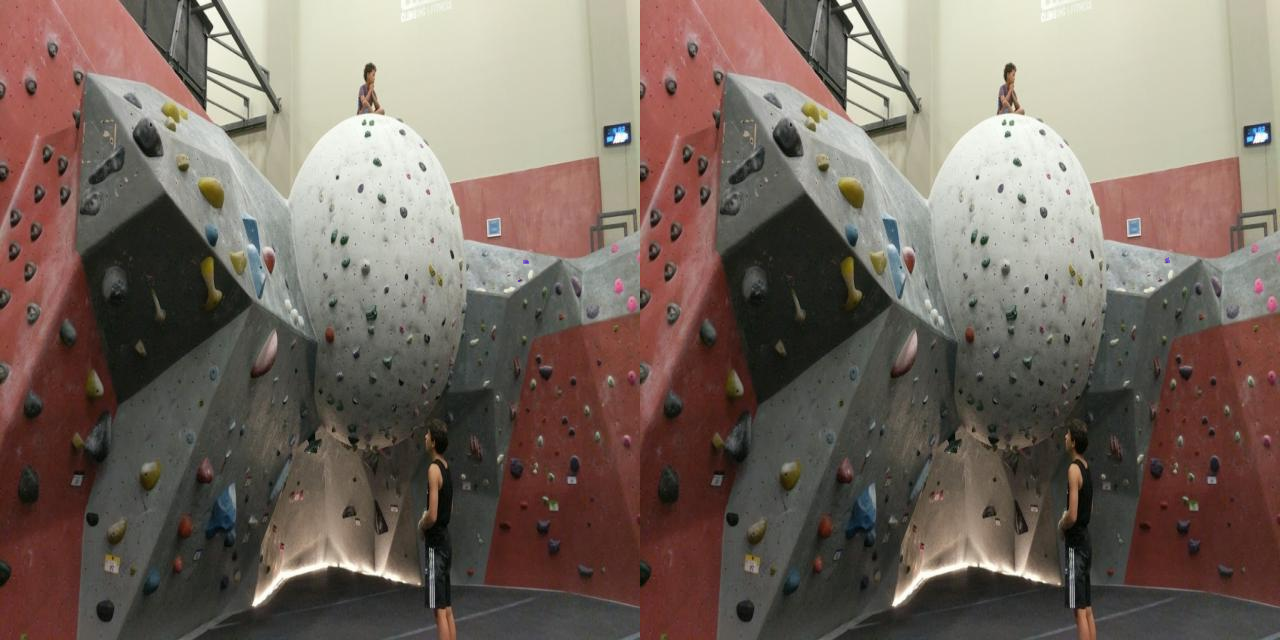

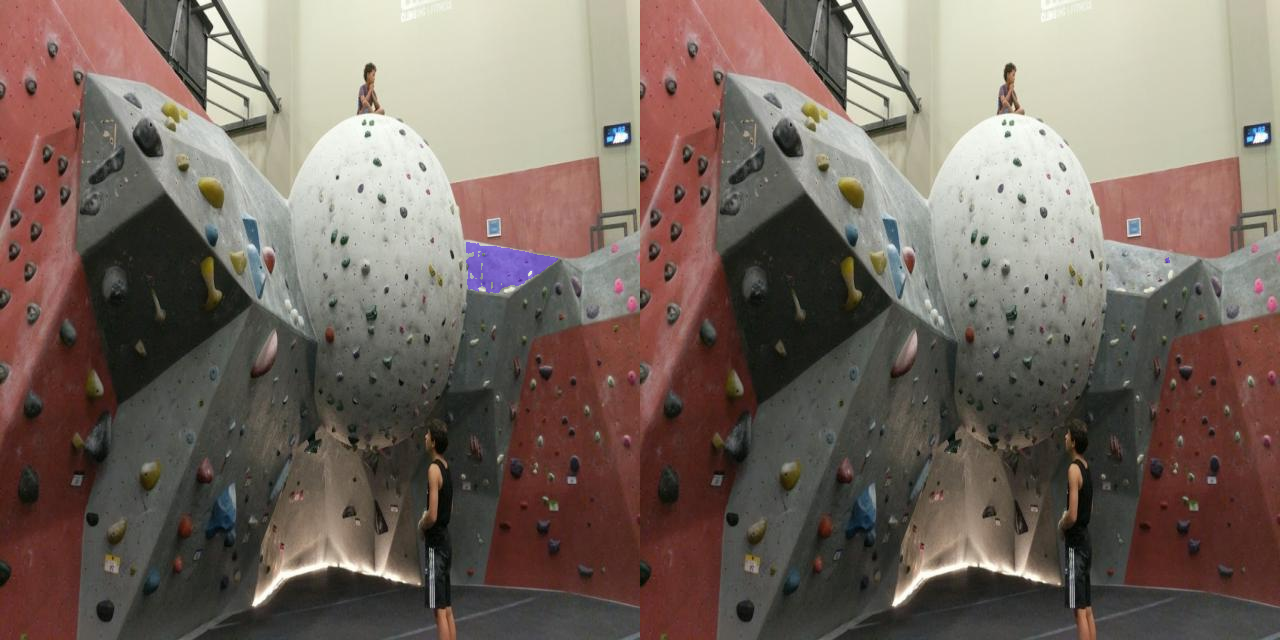

In [16]:
clip_together_imgs(mask_to_img(cls_pred_mask > 0,img),mask_to_img(gt_binary_mask,img)).show()
clip_together_imgs(mask_to_img(pred_mask > 0,img),mask_to_img(gt_binary_mask,img)).show()

In [17]:
from glob import glob
%cd runs/

run_cfgs = glob('cfg_*.json')
highest_run = max([int(cfg.split('_')[1].split('.')[0]) for cfg in run_cfgs])
run_num = highest_run + 1
print(f"Run number: {run_num}")

dataset_path = dataset.location
import os
dataset_name = os.path.basename(dataset_path)

cfg = {
    "dataset_name": dataset_name,
    "use_cnn": use_cnn,
    "resize_before_cnn": resize_before_cnn,
    "grow_masks": grow_masks,
    "mask_lora": mask_lora,
    "mask_r": mask_r,
    "vit_lora": vit_lora,
    "vit_r": vit_r,
    "vit_patch_embed": vit_patch_embed,
    "initial_lr": initial_lr,
    "weight_decay": weight_decay,
    "warmup_steps": warmup_steps,
    "total_steps": total_steps,
    "batch_size": batch_size,
    "lr_decay_steps": lr_decay_steps,
    "lr_decay_factor": lr_decay_factor,
    "run_name":run.name,
    "run_url":run.url,
    "run_grad": run_grad,
    "use_masks": use_masks,
    "dice_scale": dice_scale,
    "focal_scale": focal_scale,
    "ce_scale": ce_scale,
    "num_classes": num_classes,
    "tasks": tasks,
    "use_valid": use_valid,
    "num_refinement_steps": num_refinement_steps,
}

with open(f'cfg_{run_num}.json', 'w') as f:
    json.dump(cfg, f)

torch.save(mask_decoder.state_dict(), f'mask_decoder_{run_num}.pt')
if use_cnn:
    torch.save(cnn_sam.state_dict(), f'ladder_{run_num}.pt')
if mask_lora:
    lora_mask_decoder.save_lora_parameters(f"mask_lora_{run_num}.pt")
if vit_lora:
    lora_image_encoder.save_lora_parameters(f"vit_lora_{run_num}.pt")
if use_cls_tokens:
    # select state dict with properties num_classes, cls_iou_token, cls_mask_tokens, cls_hypernetworks_mlps, cls_iou_prediction_head
    # decoder_state_dict = {k:v for k,v in mask_decoder.state_dict().items() if k.startswith("cls")}
    torch.save(mask_decoder.state_dict(), f"cls_decoder_{run_num}.pt")
if vit_patch_embed:
    torch.save(image_encoder.patch_embed.state_dict(), f"vit_patch_embed_{run_num}.pt")
# if num_classes > 0:
#     torch.save(mask_decoder.class_tokens.state_dict(), f"class_tokens_{run_num}.pt")
#     torch.save(mask_decoder.class_prediction_head.state_dict(), f"class_prediction_head_{run_num}.pt")

%cd ..

/home/andrewhealey/sam-fine-tuning/runs
Run number: 68
/home/andrewhealey/sam-fine-tuning


In [ ]:
evaluate()

  0%|          | 0/328 [00:00<?, ?it/s]

 10%|▉         | 32/328 [00:02<00:21, 13.87it/s]


KeyboardInterrupt: 

In [ ]:
from fine_tune.datasets import load_dir_as_dataset

test_dataset = load_dir_as_dataset("datasets/own-plate-test")

test_curr_dataset = prep_datasets(test_dataset)


100%|██████████| 7/7 [00:00<00:00, 3450.48it/s]


In [ ]:
idx = -1

0 climbing-holds


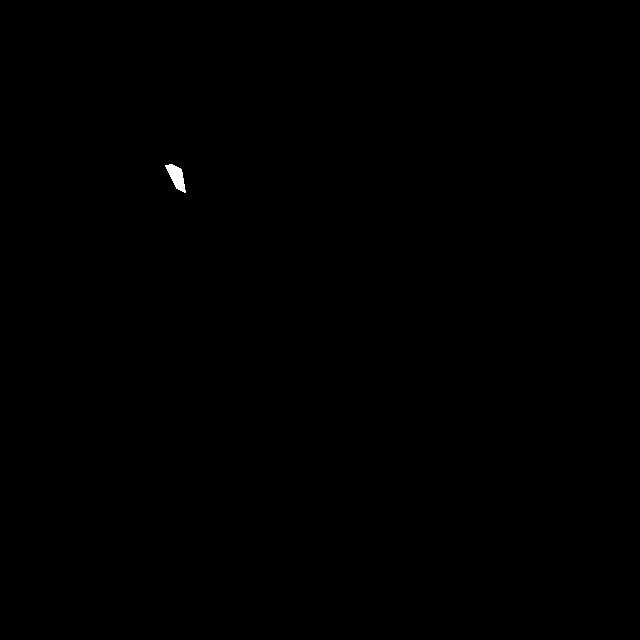

In [ ]:
from fine_tune.viz import render_prompt,mask_to_img

img,prompt = valid_curr_dataset.prompts[10]
print(prompt.gt_cls,valid_dataset.classes[prompt.gt_cls])
Image.fromarray(prompt.gt_mask).show()
# render_prompt(img,prompt,valid_dataset)# 

one mask
tensor([0], device='cuda:0') tensor(0, device='cuda:0')
Predicted IoU: 0.725114107131958
Predicted class: climbing-holds


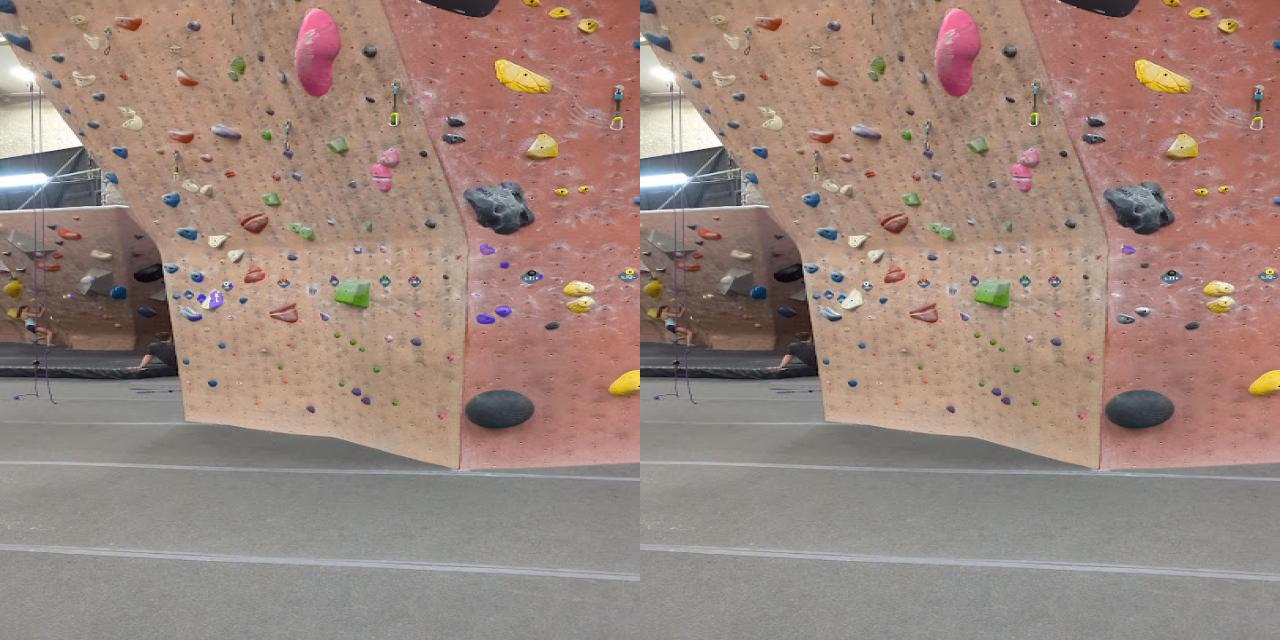

cls binary masks:


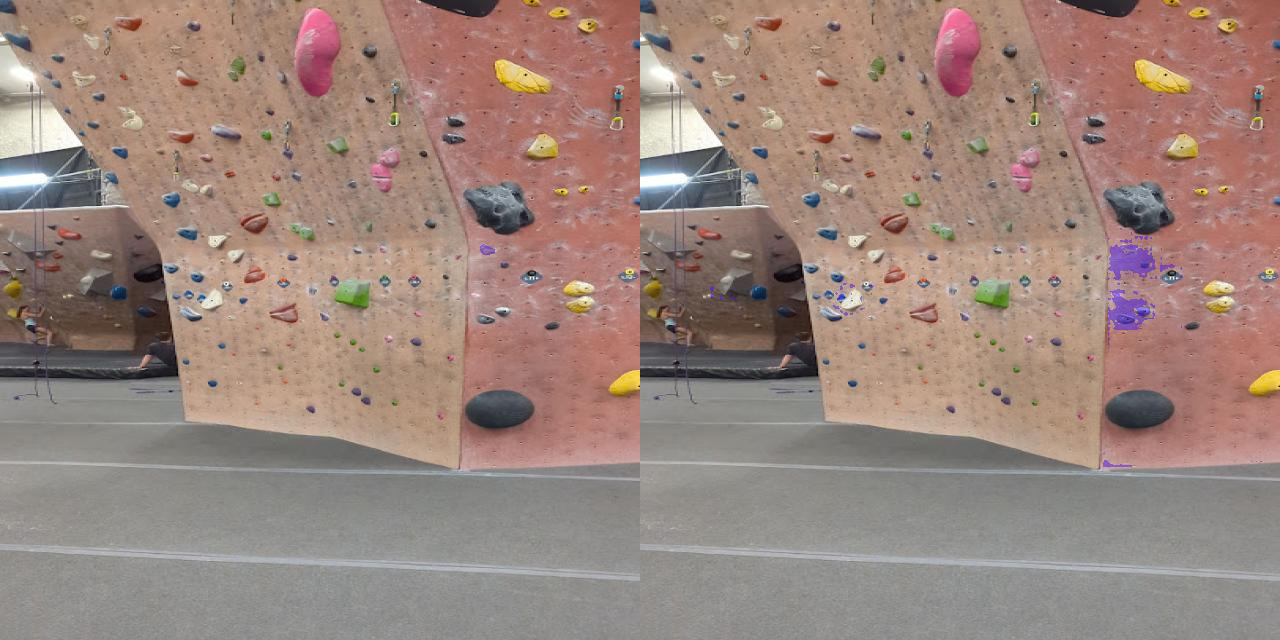

In [ ]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

decoder_input, gt_masks, (gt_cls,gt_cls_logits), sizing, img, (unresized_img,resized_img) = v_c_ds[idx]
has_fresh_prompt = True
num_refinements_left = num_refinement_steps
new_input = {**decoder_input}
while has_fresh_prompt:
    has_fresh_prompt = False

    print("one mask" if len(gt_masks) == 1 else "multiple masks")

    with torch.no_grad():
        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]
            curr_embedding = decoder_input["image_embeddings"]
            new_input["image_embeddings"] = curr_embedding + cnn_embedding
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = mask_decoder(**new_input)

    # upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
    upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
    binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

    max_idx = torch.argmax(iou_predictions).item()
    iou = iou_predictions[max_idx].item()

    gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)
    binary_mask = binary_masks[max_idx]

    if gt_cls is not None and use_cls_tokens:

        cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
        cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]

        # get focal and dice loss between cls_binary_mask and closest gt mask
        cls_gt_binary_mask,cls_binary_mask,max_iou,best_cls = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device))

        cls_pred_mask = cls_upscaled_masks[best_cls,:,:]
        
        print(gt_cls,best_cls)

    if num_refinements_left > 0:
        has_fresh_prompt = True
        num_refinements_left -= 1

        new_prompt = make_refinement_prompt(binary_mask, gt_binary_mask)
        new_decoder_input, gt_masks = curr_dataset.prompt_to_tensors(new_prompt, sizing)

        # extract image_embeddings and context_embeddings from old decoder_input
        new_input = {
                    **new_input,
                    "dense_prompt_embeddings": decoder_input["dense_prompt_embeddings"],
                    # "image_embeddings": decoder_input["image_embeddings"],
                    # "context_embeddings": decoder_input["context_embeddings"],
                    # **new_decoder_input,
        }



from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

if False:
    with torch.no_grad():

        flat_binary_mask = binary_mask.view(1,-1)
        flat_gt_binary_mask = gt_binary_mask.view(1,-1)

        focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
        dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
        iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
        loss = focal_loss + dice_loss
        print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

print("Predicted IoU:",iou)
print("Predicted class:",valid_dataset.classes[best_cls])
# print("Predicted class:",torch.argmax(pred_logits).item(),"GT class:",torch.argmax(gt_cls_logits[0]).item())

clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()
# clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

print("cls binary masks:")
clip_together_imgs(mask_to_img(cls_binary_masks[0],img),mask_to_img(cls_binary_masks[1],img)).show()

torch.Size([1, 1, 640, 640])


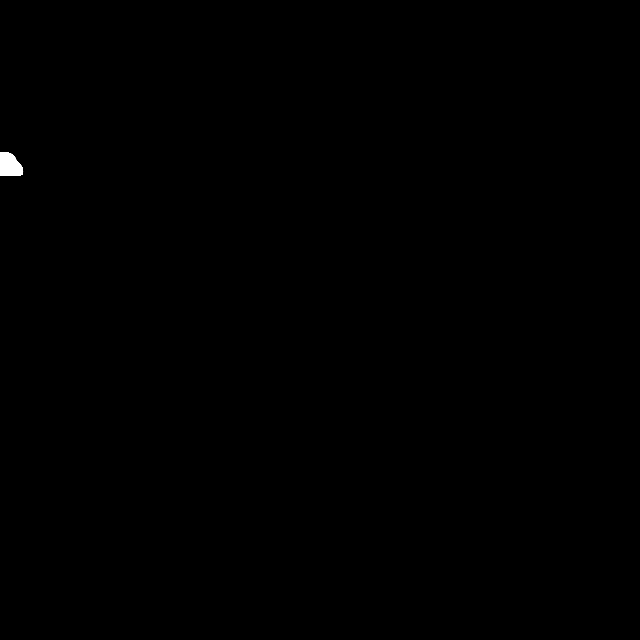

In [ ]:
upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
# upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)

print(upscaled_masks.shape)
Image.fromarray(upscaled_masks.cpu().numpy()[0,0] * 255).convert("RGB")

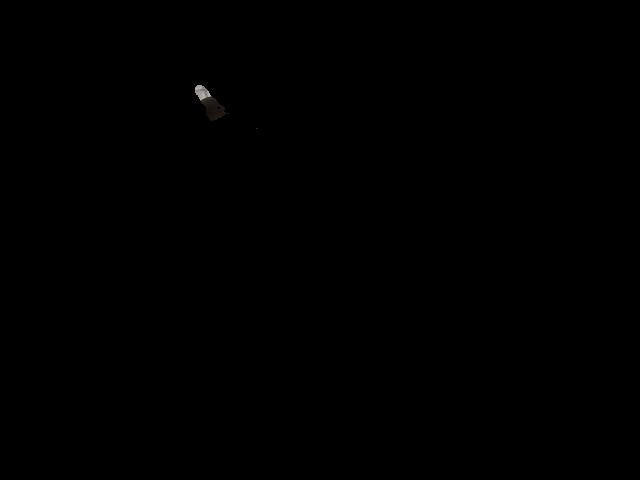

In [ ]:
# upscale low_res_masks to 1024x1024
high_res_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False).detach().cpu().numpy()[0,0]

thresholded = (high_res_masks > 0).astype(np.uint8)
Image.fromarray(img * thresholded[...,None]).convert("RGB")

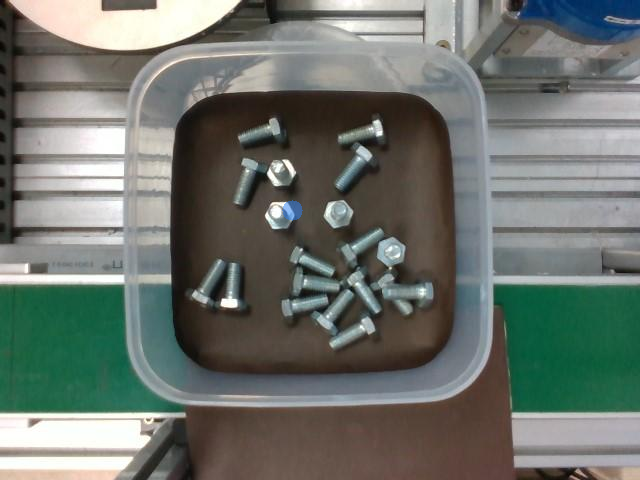

In [ ]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
# print(prompt.mask.shape)
render_prompt(name,prompt,train_dataset)

# Predict on Test Set

# Segment Everything

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.1)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

# Distance utils

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(train_dataset.images.keys()))

rand_img_dets = train_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances
    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map
empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))

# Progressive mask gen

In [ ]:
import supervision as sv

class LabellingSession:
    def __init__(self,img:np.ndarray):
        self.img = img
        self.sv_dataset = sv.DetectionDataset(
            classes=train_dataset.classes,
            images={
                "test":img
            },
            annotations={
                "test":sv.Detections.empty()
            }
        )
        self.torch_dataset = SamNextMaskDataset(self.sv_dataset,predictor,device)
        self.annotator = sv.MaskAnnotator()
    
    def update_detections(self,detections:sv.Detections):
        self.sv_dataset.annotations["test"] = detections

    def img_to_tensors(self):
        return self.torch_dataset[0]
    
    def show(self):
        return Image.fromarray(self.annotator.annotate(scene=self.img,detections=self.sv_dataset.annotations["test"]))
    
    @torch.no_grad()
    def get_next_mask(self):
        decoder_input, _, (input_size,original_size), img, (unresized_img,resized_img) = self.img_to_tensors()
        H,W,_ = img.shape

        new_input = {**decoder_input}

        if vit_lora:
            sam_embedding = image_encoder(resized_img)[0]
            new_input["image_embeddings"] = sam_embedding

        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]

            curr_embedding = new_input["image_embeddings"]

            new_input["image_embeddings"] = curr_embedding + cnn_embedding

        low_res_masks, iou_predictions = mask_decoder(**new_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        assert len(iou_predictions.shape) == 1, f"IoU predictions shape is {iou_predictions.shape}"

        pred_idx = torch.argmax(iou_predictions)
        pred_mask = high_res_masks[pred_idx] > 0

        # new detection
        masks = pred_mask[None, :, :].cpu().numpy()
        class_id = 0
        new_dets = sv.Detections(
            xyxy=sv.Detections.mask_to_xyxy(masks),
            mask=masks,
            class_id=np.array([class_id]),
        )

        self.update_detections(new_dets)


In [ ]:
demo_img = cv2.imread("test.jpg")

session = LabellingSession(demo_img)

In [ ]:
session.get_next_mask()

session.show